In [1]:
import pandas as pd
import warnings
from preprocessing import data_preprocessor
import numpy as np
from model_eval import model_eval_report

In [2]:
data = pd.read_table("XYZCorp_LendingData.txt")
event_rate = (data.default_ind.value_counts()[1]/data.shape[0])*100

#data is for 2018 so using 2018 to calculate total credit age
data_year = 2018

/var/folders/1y/hs8w9lqd56df4lg10hxlx_dw0000gn/T/ipykernel_10528/46851181.py:1: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table("XYZCorp_LendingData.txt")


In [3]:
data = data_preprocessor(data)

In [9]:
num_features = list(data.select_dtypes(exclude=['object']).columns)
num_features.remove('default_ind')
obj_features= list(data.select_dtypes(include=['object']).columns)  # here all object features are nominal
target = 'default_ind'

In [32]:
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler, PowerTransformer, KBinsDiscretizer, StandardScaler
from sklearn.compose import ColumnTransformer
import scipy

nominal_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(drop='first', handle_unknown = 'ignore'))
numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean'),PowerTransformer('yeo-johnson'),MinMaxScaler()) #,PowerTransformer('yeo-johnson')
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('nominal_pipeline',nominal_pipeline,obj_features),
    ('numeric_pipeline',numeric_pipeline,num_features)
])
preprocessing_pipeline

ColumnTransformer(transformers=[('nominal_pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['term', 'grade', 'home_ownership',
                                  'verification_status', 'pymnt_plan',
                                  'purpose', 'title', 'zip_code', 'addr_state',
                                  'initial_list_status', 'application_type'])...
                                  'last_credit_pull_d__monthyear',
                                  'last_pymnt_d__monthyear',
                                  'next_pymnt_d__monthyear',
                                  'earliest_cr_line__monthyear',
                                  'tot_cur_bal_normalized',
                                  'total_rev_hi_lim_normalized',
                                  'total_rec_prncp_normalized',
                                  'total_rec_int_normalized',
                                  'annual_inc_normalized',
                                  'revol_bal_normalized',
                                  'tot_coll_amt_normalized',
                                  'total_rec_late_fee_normalized',
                                  'recoveries_normalized', ...])])

## Model Building

In [19]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier

In [11]:
train = data[data['issue_d__monthyear'] < 201506]
test = data[data['issue_d__monthyear'] >= 201506]

del train['issue_d__monthyear']
del test['issue_d__monthyear']

In [12]:
train.shape,test.shape

((855969, 44), (0, 44))

In [16]:
num_features.remove('issue_d__monthyear')
X_train = train[num_features + obj_features]
y_train = train[target]

X_test = test[num_features + obj_features]
y_test = test[target]

In [17]:
from sklearn.model_selection import train_test_split, cross_validate
X = data[num_features + obj_features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [33]:
# model = RandomForestClassifier(n_estimators= 100, min_samples_leaf = 100,random_state=201)
model = LogisticRegression(solver='liblinear')
# model=LogisticRegression(solver='liblinear')
name = 'LR model'

pipelined_model = make_pipeline(preprocessing_pipeline,model)
pipelined_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['term', 'grade',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'title', 'zip_code',
                                                   'addr_state',
                                                   'init...
                                                   'next_pymnt_d__monthyear',
                                                   'earliest_cr_line__monthyear',
                                                   'tot_cur_bal_normalized',
                                                   'total_rev_hi_lim_normalized',
                                                   'total_rec_prncp_normalized',
                                                   'total_rec_int_normalized',
                                                   'annual_inc_normalized',
                                                   'revol_bal_normalized',
                                                   'tot_coll_amt_normalized',
                                                   'total_rec_late_fee_normalized',
                                                   'recoveries_normalized', ...])])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [34]:
from sklearn.model_selection import train_test_split, cross_validate
cv = cross_validate(pipelined_model,X_train,y_train, cv = 3, return_train_score=True, scoring='roc_auc')

In [35]:
cv

{'fit_time': array([6.78508902, 6.79424405, 6.66279006]),
 'score_time': array([0.59624124, 0.56521392, 0.57005501]),
 'test_score': array([0.99525851, 0.99583411, 0.99541676]),
 'train_score': array([0.99667051, 0.99646827, 0.9965148 ])}

In [36]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Undersample the majority class
sampler = RandomUnderSampler(random_state=42)
X_res_train, y_res_train = sampler.fit_resample(X_train, y_train)

In [37]:
pipelined_model.fit(X_res_train,y_res_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['term', 'grade',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'title', 'zip_code',
                                                   'addr_state',
                                                   'init...
                                                   'next_pymnt_d__monthyear',
                                                   'earliest_cr_line__monthyear',
                                                   'tot_cur_bal_normalized',
                                                   'total_rev_hi_lim_normalized',
                                                   'total_rec_prncp_normalized',
                                                   'total_rec_int_normalized',
                                                   'annual_inc_normalized',
                                                   'revol_bal_normalized',
                                                   'tot_coll_amt_normalized',
                                                   'total_rec_late_fee_normalized',
                                                   'recoveries_normalized', ...])])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

Evaluation of LR model model
   fit_time  score_time  test_score  train_score
0  6.785089    0.596241    0.995259     0.996671
1  6.794244    0.565214    0.995834     0.996468
2  6.662790    0.570055    0.995417     0.996515


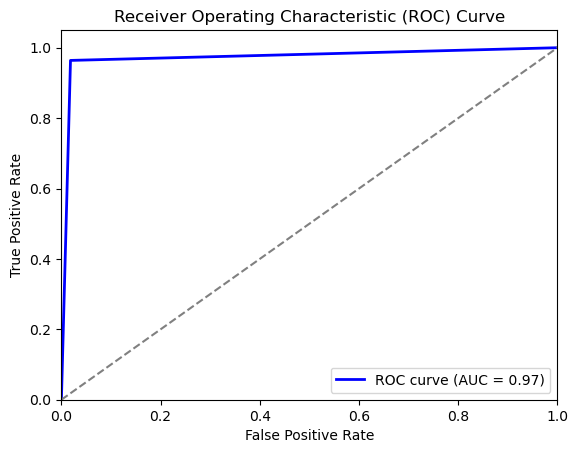

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    404775
           1       0.75      0.96      0.84     23210

    accuracy                           0.98    427985
   macro avg       0.87      0.97      0.92    427985
weighted avg       0.98      0.98      0.98    427985



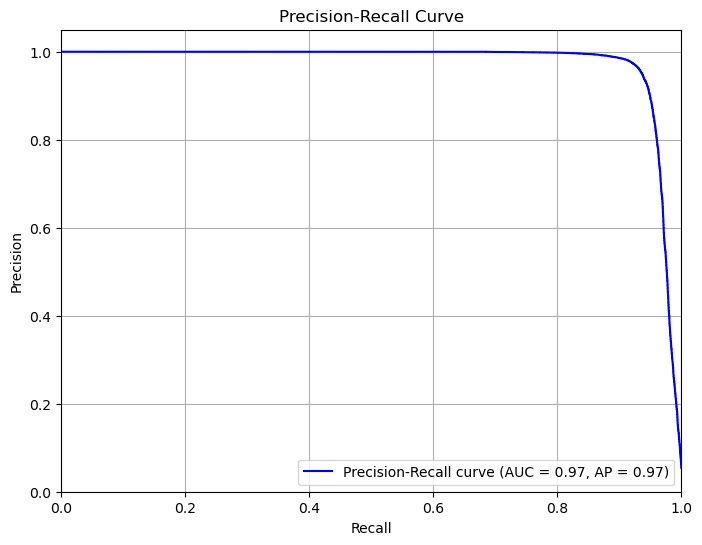

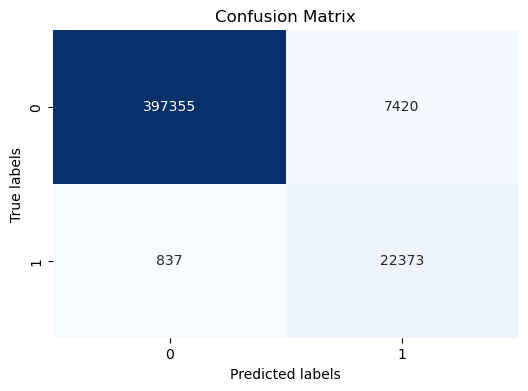

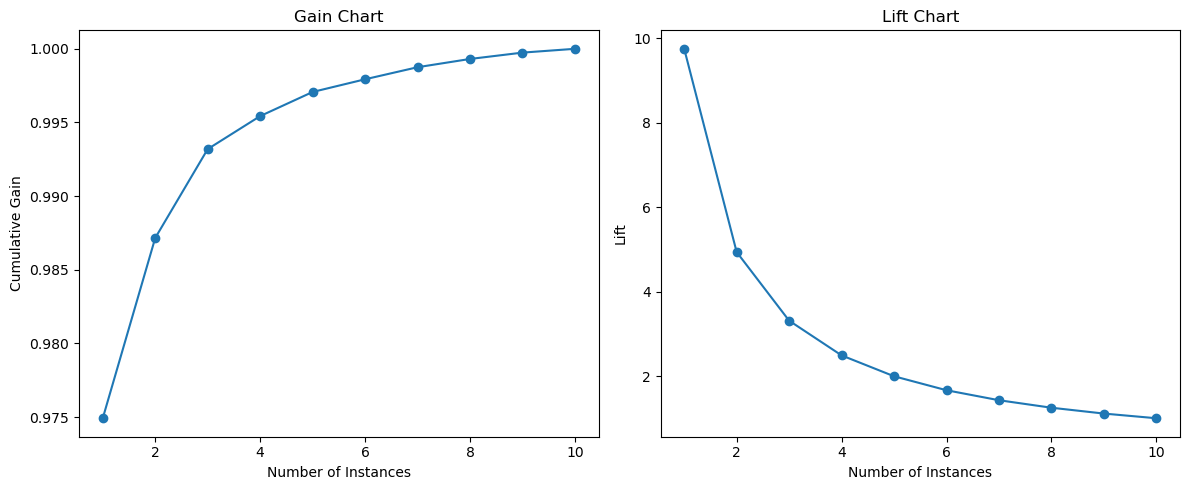

In [38]:
X_res_test, y_res_test = sampler.fit_resample(X_test, y_test)
model_eval_report(pipelined_model,X_test,y_test, name, cv)

In [39]:
models= {
    'LR': LogisticRegression(solver='liblinear'),
    'DT': DecisionTreeClassifier(random_state=42),
    'RF':RandomForestClassifier(random_state=201),
    'ADAboost': AdaBoostClassifier(),
    'XGB': XGBClassifier(random_state = 100),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=201)
    }

Evaluation of LR model
   fit_time  score_time  test_score  train_score
0  6.840480    0.574644    0.966585     0.972348
1  7.117637    0.557099    0.969300     0.971325
2  6.804980    0.562332    0.967716     0.972242


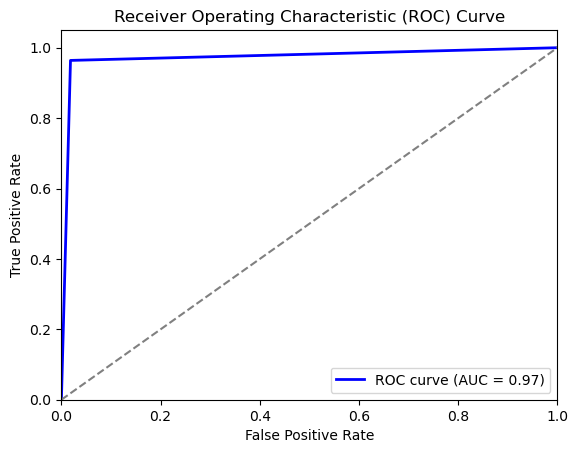

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    404775
           1       0.75      0.96      0.84     23210

    accuracy                           0.98    427985
   macro avg       0.87      0.97      0.92    427985
weighted avg       0.98      0.98      0.98    427985



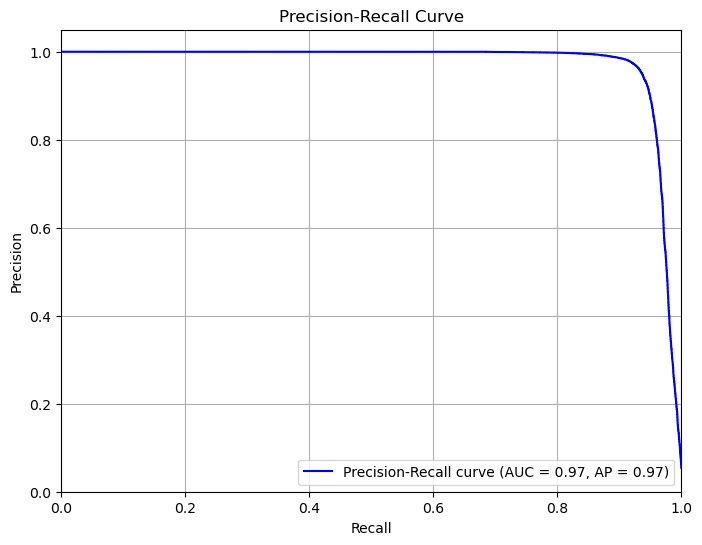

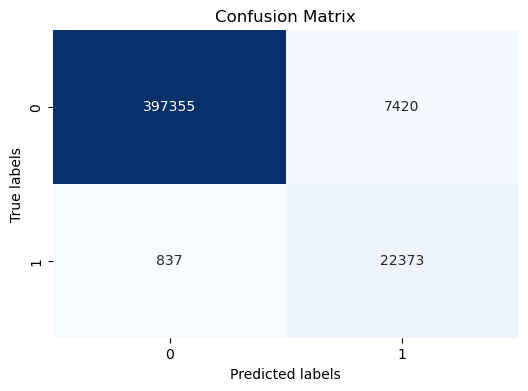

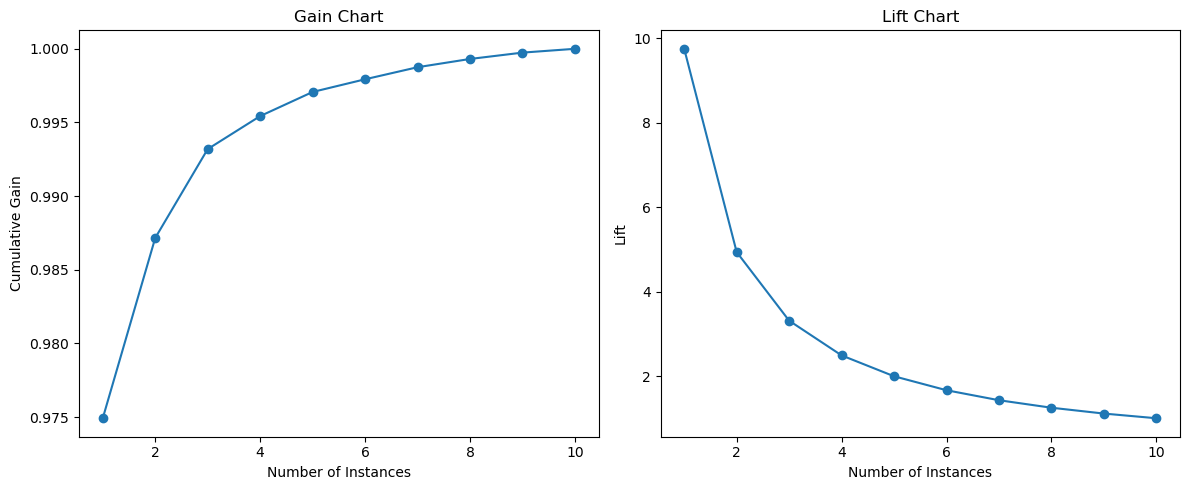

Evaluation of DT model
    fit_time  score_time  test_score  train_score
0  11.358366    0.568389    0.998389          1.0
1  10.200465    0.561378    0.998710          1.0
2   9.991759    0.567998    0.998645          1.0


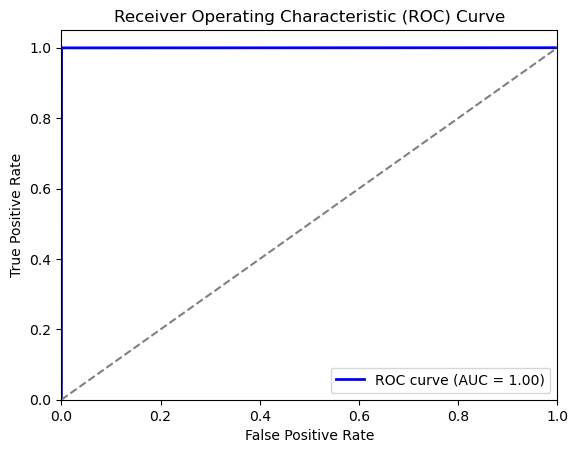

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    404775
           1       0.99      1.00      1.00     23210

    accuracy                           1.00    427985
   macro avg       1.00      1.00      1.00    427985
weighted avg       1.00      1.00      1.00    427985



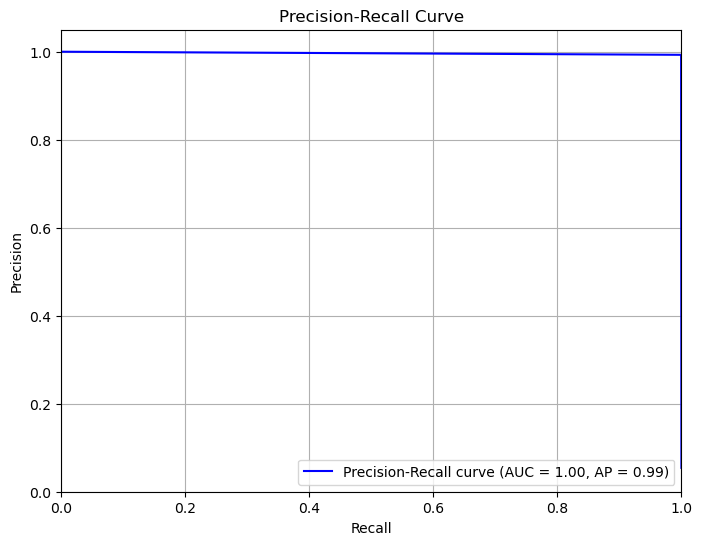

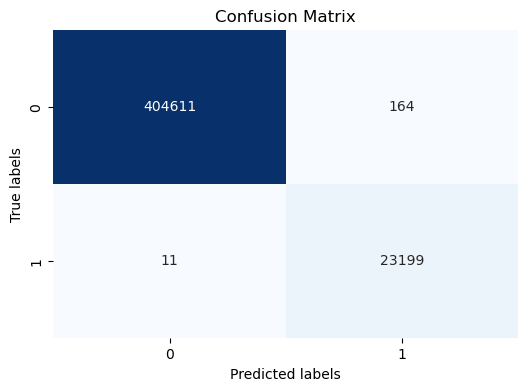

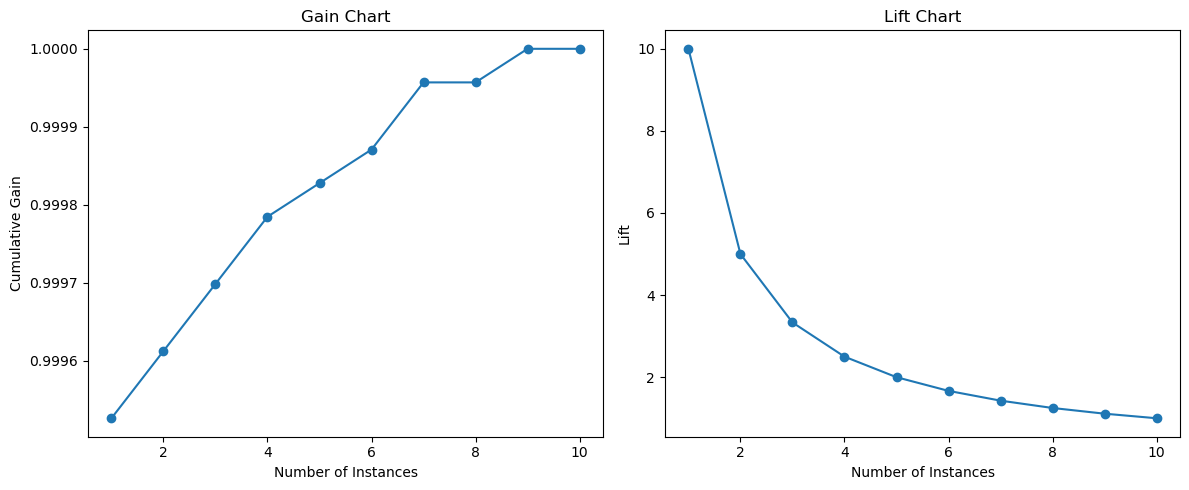

Evaluation of RF model
     fit_time  score_time  test_score  train_score
0  104.149714    4.319302    0.938599          1.0
1  108.470319    4.326766    0.937282          1.0
2  101.280788    4.183194    0.950163          1.0


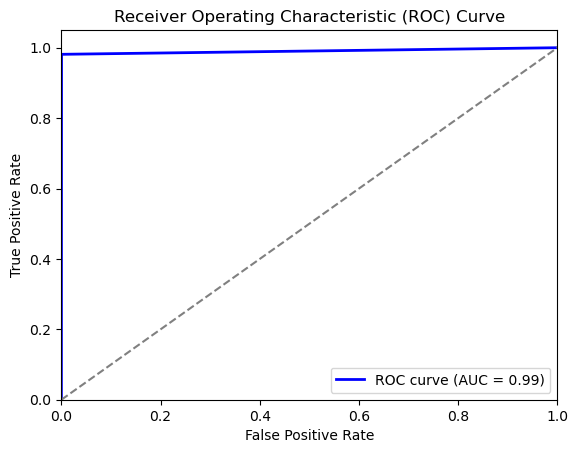

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    404775
           1       1.00      0.98      0.99     23210

    accuracy                           1.00    427985
   macro avg       1.00      0.99      0.99    427985
weighted avg       1.00      1.00      1.00    427985



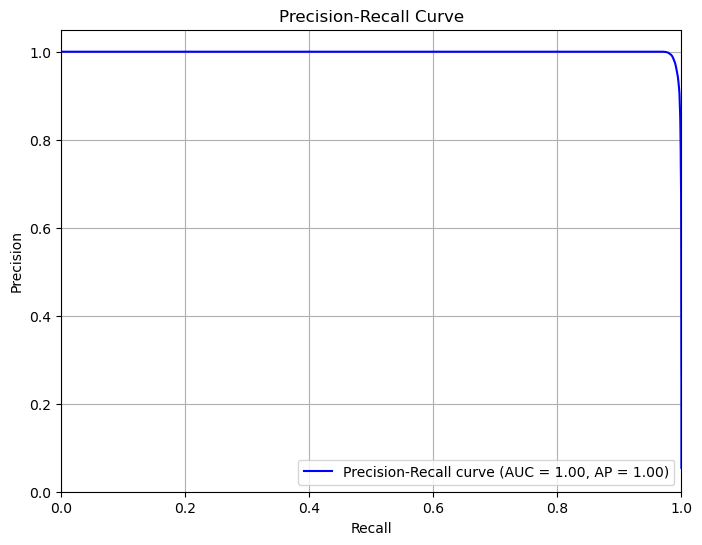

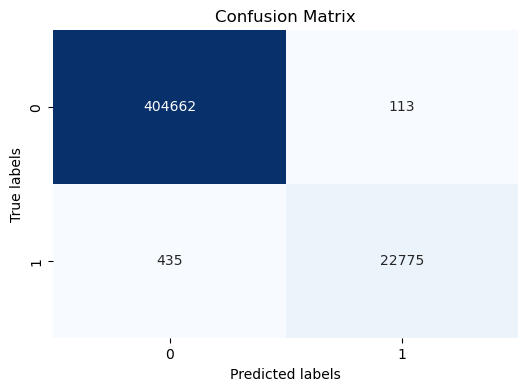

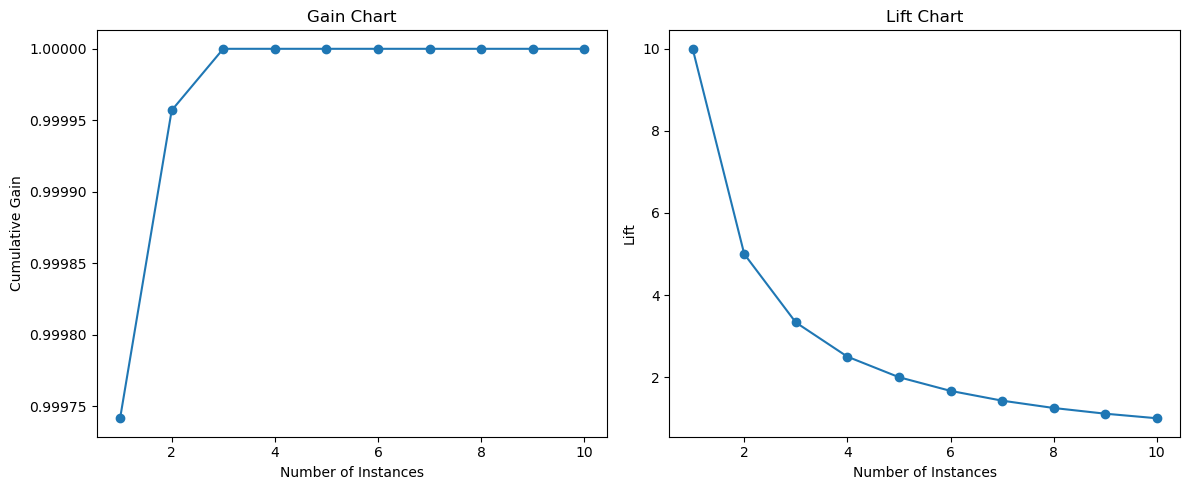

Evaluation of ADAboost model
    fit_time  score_time  test_score  train_score
0  27.197282    1.219754    0.999742     0.999613
1  26.936252    1.169410    0.999355     0.999936
2  27.231027    1.176087    0.999484     0.999774


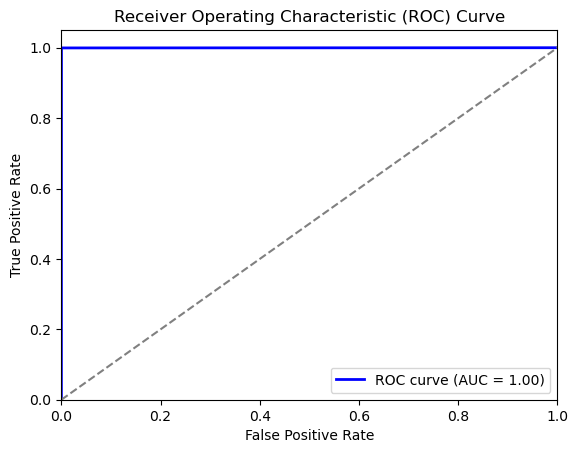

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    404775
           1       1.00      1.00      1.00     23210

    accuracy                           1.00    427985
   macro avg       1.00      1.00      1.00    427985
weighted avg       1.00      1.00      1.00    427985



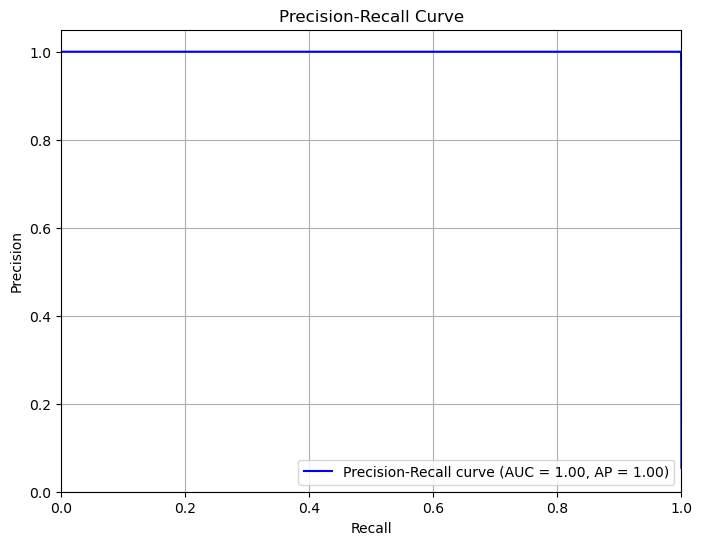

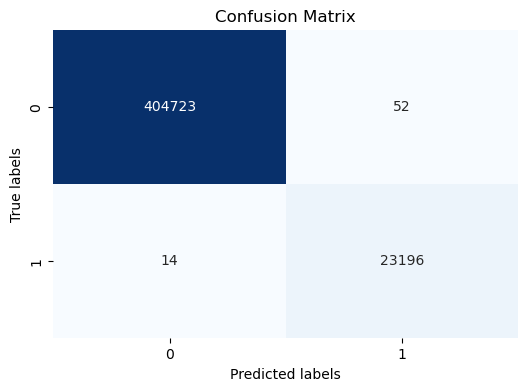

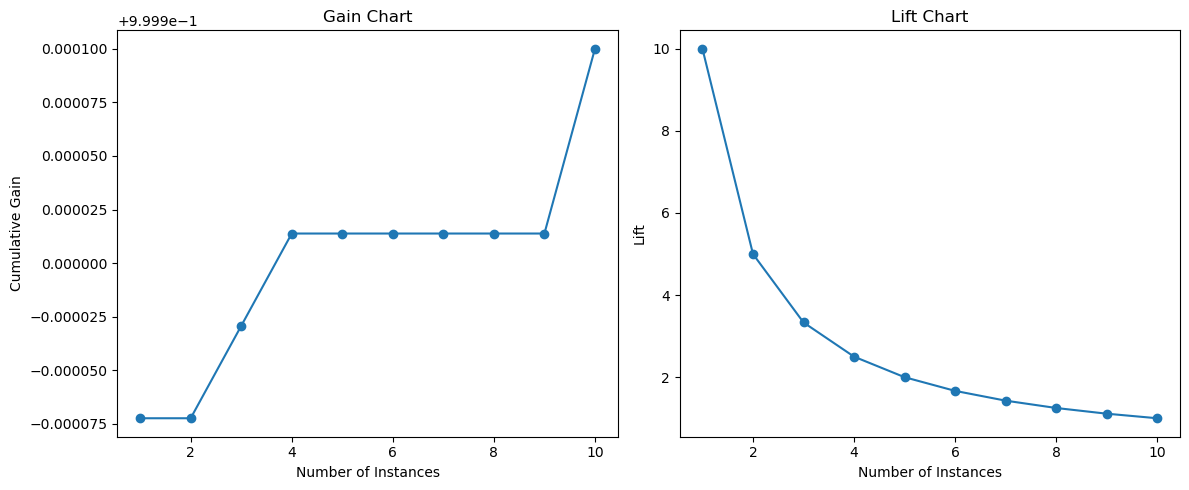

Evaluation of XGB model
   fit_time  score_time  test_score  train_score
0   6.15806    0.778121    0.999871          1.0
1   6.01481    0.746144    0.999225          1.0
2   6.55449    0.753926    0.999484          1.0


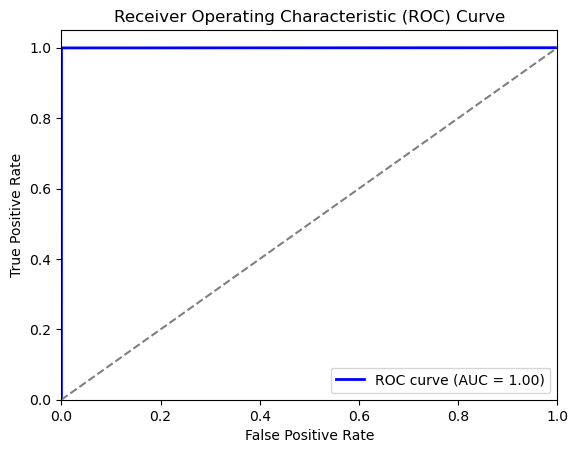

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    404775
           1       1.00      1.00      1.00     23210

    accuracy                           1.00    427985
   macro avg       1.00      1.00      1.00    427985
weighted avg       1.00      1.00      1.00    427985



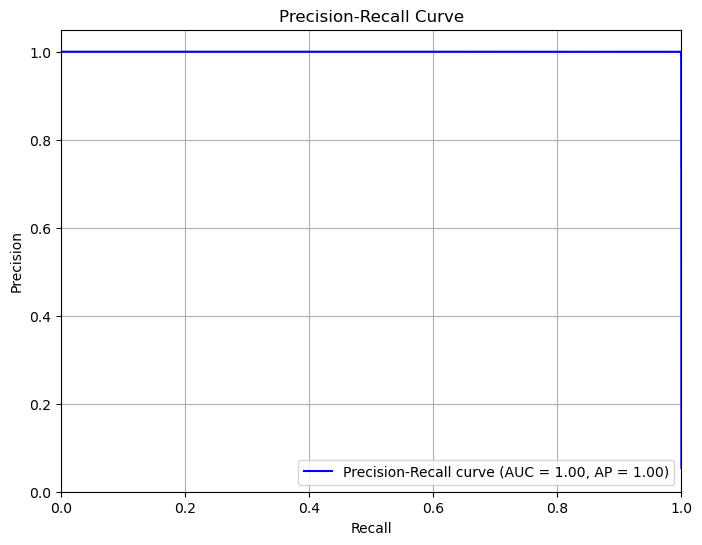

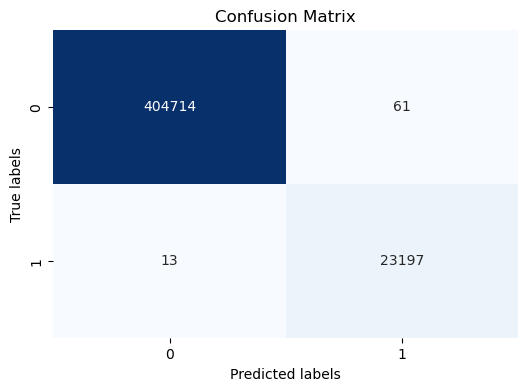

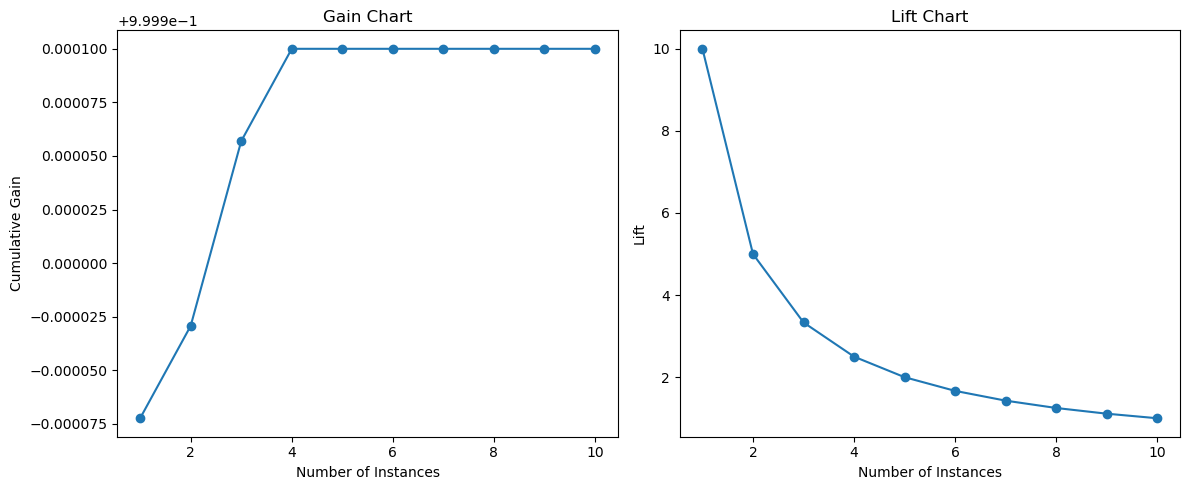

Evaluation of CatBoost model
    fit_time  score_time  test_score  train_score
0  37.580087    0.679895    0.998644     0.998805
1  39.273427    0.663800    0.999096     0.999613
2  37.751678    0.652422    0.998450     0.998708


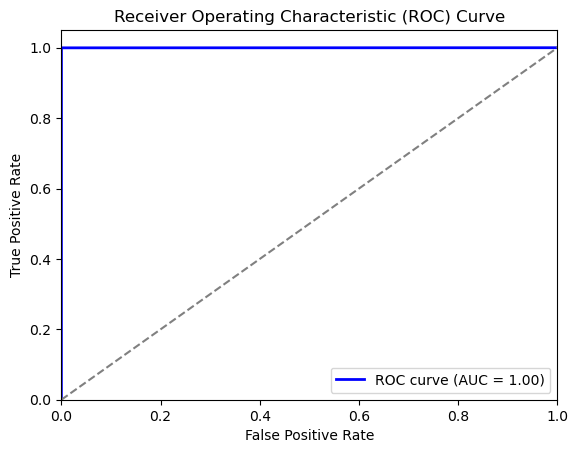

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    404775
           1       1.00      1.00      1.00     23210

    accuracy                           1.00    427985
   macro avg       1.00      1.00      1.00    427985
weighted avg       1.00      1.00      1.00    427985



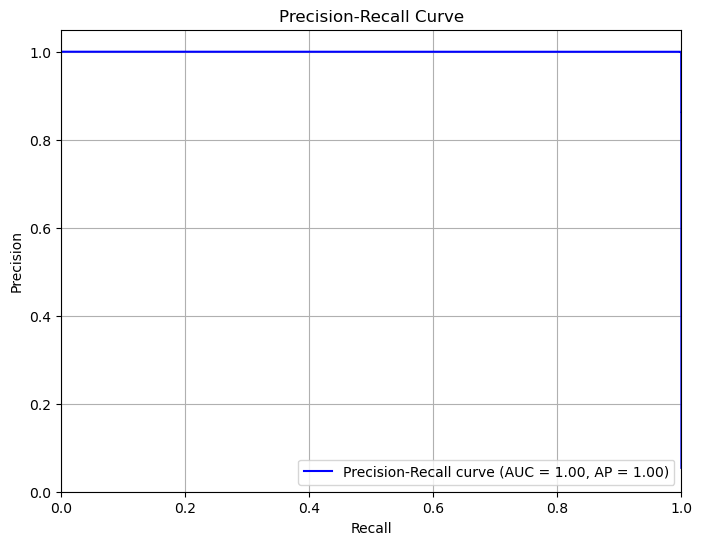

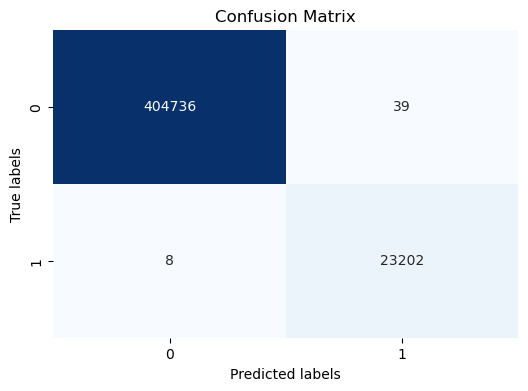

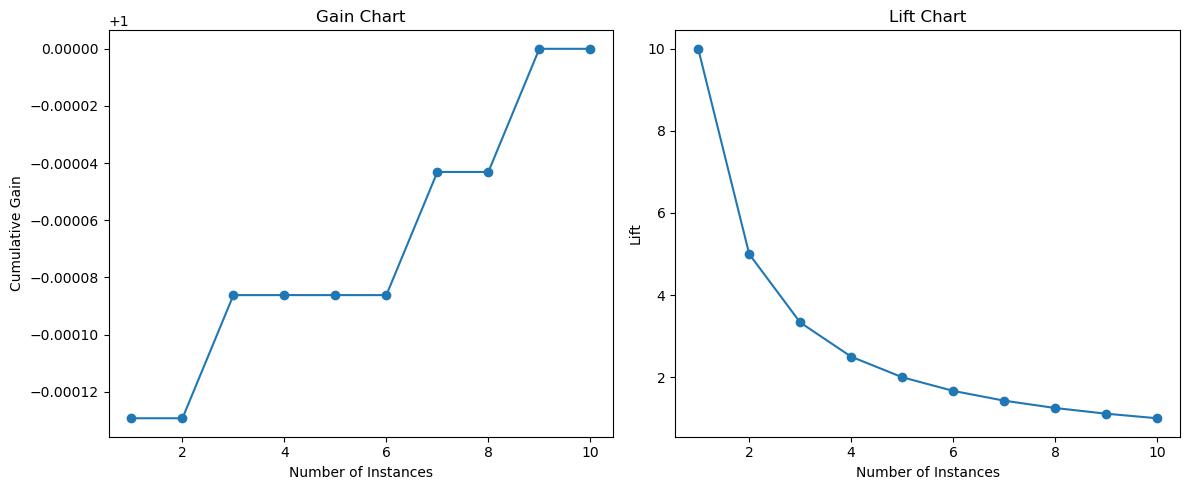

In [40]:
for name,model in models.items():
    pipelined_model = make_pipeline(preprocessing_pipeline,model)
    cv = cross_validate(pipelined_model,X_train,y_train, cv = 3, return_train_score=True, scoring='f1')
    sampler = RandomUnderSampler(random_state=42)
    X_res_train, y_res_train = sampler.fit_resample(X_train, y_train)
    pipelined_model.fit(X_res_train,y_res_train)
    model_eval_report(pipelined_model,X_test,y_test, name, cv)
    